# 01 - Load and Explore Cora 
 
Chargement, nettoyage et statistiques de base.

In [7]:
import os 
from pathlib import Path 
 
import networkx as nx 
import numpy as np 
import pandas as pd 
 
print('cwd =', os.getcwd()) 
 
# Chemins robustes: notebook dans /notebooks, donn?es dans /data 
project_root = Path.cwd().parent 
content_path = project_root / 'data' / 'cora.content' 
cites_path = project_root / 'data' / 'cora.cites' 
 
print('content_path =', content_path) 
print('cites_path   =', cites_path) 
print('exists? ->', content_path.exists(), cites_path.exists()) 
 
if not content_path.exists() or not cites_path.exists(): 
    raise FileNotFoundError('V?rifie le dossier projet et les chemins vers data/cora.*') 
 
# Lecture cora.content : format (node_id \t features... \t label) 
nodes = [] 
labels = {} 
with open(content_path, 'r', encoding='utf-8') as f: 
    for line in f: 
        parts = line.strip().split() 
        nid = parts[0] 
        nodes.append(nid) 
        labels[nid] = parts[-1] 
 
# Lecture ar?tes 
G = nx.Graph() 
G.add_nodes_from(nodes) 
with open(cites_path, 'r', encoding='utf-8') as f: 
    for line in f: 
        u, v = line.strip().split() 
        if u in G and v in G: 
            G.add_edge(u, v) 
 
# Nettoyage 
G.remove_edges_from(nx.selfloop_edges(G)) 
G = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
 
deg = [d for _, d in G.degree()] 
print('n, m:', G.number_of_nodes(), G.number_of_edges()) 
print('Degrees: min, max, mean:', np.min(deg), np.max(deg), np.mean(deg)) 

cwd = c:\Users\Oussama HAJJI\Desktop\Graoh Theory\notebooks
content_path = c:\Users\Oussama HAJJI\Desktop\Graoh Theory\data\cora.content
cites_path   = c:\Users\Oussama HAJJI\Desktop\Graoh Theory\data\cora.cites
exists? -> True True
n, m: 2485 5069
Degrees: min, max, mean: 1 168 4.0796780684104625


# Split Link Prediction (Ajout) 
 
Ajout? sans supprimer la partie exploration.

In [8]:
from pathlib import Path 
import time 
import random 
import networkx as nx 
import numpy as np 
 
# Paths 
project_root = Path.cwd().parent 
content_path = project_root / 'data' / 'cora.content' 
cites_path = project_root / 'data' / 'cora.cites' 
 
# Debug mode: reduce graph size for faster iteration 
DEBUG_SMALL = False 
N_DEBUG = 800 
 
 
def train_test_split_edges_fast(G, test_frac=0.1, seed=42): 
    random.seed(seed) 
    if G.number_of_edges() == 0: 
        return G.copy(), [], [] 
 
    tree = nx.minimum_spanning_tree(G) 
    tree_edges = {tuple(sorted(e)) for e in tree.edges()} 
    all_edges = [tuple(sorted(e)) for e in G.edges()] 
    removable = [e for e in all_edges if e not in tree_edges] 
 
    num_test = min(int(len(all_edges) * test_frac), len(removable)) 
    test_edges = random.sample(removable, k=num_test) if num_test > 0 else [] 
 
    G_train = G.copy() 
    G_train.remove_edges_from(test_edges) 
 
    edge_set = {tuple(sorted(e)) for e in G.edges()} 
    nodes = list(G.nodes()) 
    test_neg = set() 
    while len(test_neg) < len(test_edges): 
        u, v = random.sample(nodes, 2) 
        uv = tuple(sorted((u, v))) 
        if uv not in edge_set and uv not in test_neg: 
            test_neg.add(uv) 
 
    return G_train, test_edges, list(test_neg) 
 
 
start = time.perf_counter() 
 
nodes = [] 
with open(content_path, 'r', encoding='utf-8') as f: 
    for line in f: 
        parts = line.strip().split() 
        nodes.append(parts[0]) 
 
G = nx.Graph() 
G.add_nodes_from(nodes) 
with open(cites_path, 'r', encoding='utf-8') as f: 
    for line in f: 
        u, v = line.strip().split() 
        if u in G and v in G: 
            G.add_edge(u, v) 
 
G.remove_edges_from(nx.selfloop_edges(G)) 
G = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
 
if DEBUG_SMALL and G.number_of_nodes() > N_DEBUG: 
    random.seed(42) 
    keep_nodes = set(random.sample(list(G.nodes()), N_DEBUG)) 
    G = G.subgraph(keep_nodes).copy() 
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
 
mid = time.perf_counter() 
G_train, test_pos, test_neg = train_test_split_edges_fast(G, test_frac=0.1, seed=42) 
end = time.perf_counter() 
 
print('DEBUG_SMALL  :', DEBUG_SMALL) 
print('Original graph used:', G.number_of_nodes(), 'nodes,', G.number_of_edges(), 'edges') 
print('Train graph   :', G_train.number_of_nodes(), 'nodes,', G_train.number_of_edges(), 'edges') 
print('Test positives:', len(test_pos)) 
print('Test negatives:', len(test_neg)) 
print(f'Load/build time: {mid - start:.3f}s') 
print(f'Split time     : {end - mid:.3f}s') 
print(f'Total time     : {end - start:.3f}s') 


DEBUG_SMALL  : False
Original graph used: 2485 nodes, 5069 edges
Train graph   : 2485 nodes, 4563 edges
Test positives: 506
Test negatives: 506
Load/build time: 0.322s
Split time     : 0.118s
Total time     : 0.440s


In [9]:
import networkx as nx 
from sklearn.metrics import roc_auc_score, average_precision_score 
import numpy as np 
 
def common_neighbors_score(G, u, v): 
    return len(list(nx.common_neighbors(G, u, v))) 
 
def jaccard_score(G, u, v): 
    return list(nx.jaccard_coefficient(G, [(u,v)]))[0][2] 
 
def adamic_adar_score(G, u, v): 
    return list(nx.adamic_adar_index(G, [(u,v)]))[0][2] 
 
def score_pairs(G, pairs, score_fn): 
    scores = [] 
    for u,v in pairs: 
        try: 
            s = score_fn(G, u, v) 
        except: 
            s = 0.0 
        scores.append(s if s is not None else 0.0) 
    return np.array(scores) 
 
# Exemple d'?valuation 
def evaluate_method(G_train, test_pos, test_neg, score_fn): 
    pos_scores = score_pairs(G_train, test_pos, score_fn) 
    neg_scores = score_pairs(G_train, test_neg, score_fn) 
    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))]) 
    y_scores = np.concatenate([pos_scores, neg_scores]) 
    auc = roc_auc_score(y_true, y_scores) 
    ap = average_precision_score(y_true, y_scores) 
    return auc, ap 
 
# Exemples rapides 
for name, fn in [ 
    ('Common Neighbors', common_neighbors_score), 
    ('Jaccard', jaccard_score), 
    ('Adamic-Adar', adamic_adar_score), 
]: 
    auc, ap = evaluate_method(G_train, test_pos, test_neg, fn) 
    print(f'{name:18s} | AUC={auc:.4f} | AP={ap:.4f}') 

Common Neighbors   | AUC=0.7927 | AP=0.7897
Jaccard            | AUC=0.7915 | AP=0.7868
Adamic-Adar        | AUC=0.7939 | AP=0.7951


# Node2Vec + Logistic Regression 
 
Embeddings Node2Vec puis classification LR pour la pr?diction de liens.

In [10]:
# Node2Vec + Logistic Regression 
from node2vec import Node2Vec 
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, average_precision_score 
import numpy as np 
import random 
 
# training node2vec on G_train 
node2vec = Node2Vec(
    G_train,
    dimensions=32,
    walk_length=20,
    num_walks=40,
    workers=4
)
model = node2vec.fit(window=5, min_count=1)  # version simple (rapide)
 
def get_embedding(u): 
    # keys are strings if original node ids are strings 
    key = str(u) 
    return model.wv[key] 
 
def pair_to_feature(u, v, method='hadamard'): 
    eu = get_embedding(u) 
    ev = get_embedding(v) 
    if method == 'hadamard': 
        return eu * ev 
    elif method == 'concat': 
        return np.concatenate([eu, ev]) 
    elif method == 'avg': 
        return (eu + ev) / 2 
    else: 
        return eu * ev 
 
# Prepare train pairs for LR (we need a train set of pos/neg) 
# Here, sample negatives for train with same count as train positives: 
train_edges = list(G_train.edges()) 
random.seed(42) 
train_pos = random.sample(train_edges, int(len(train_edges) * 0.1))  # sample subset for speed 
train_neg = [] 
nodes = list(G_train.nodes()) 
while len(train_neg) < len(train_pos): 
    u, v = random.sample(nodes, 2) 
    if not G_train.has_edge(u, v): 
        train_neg.append((u, v)) 
 
X_train = np.array([pair_to_feature(u, v) for (u, v) in (train_pos + train_neg)]) 
y_train = np.array([1] * len(train_pos) + [0] * len(train_neg)) 
 
# scale + fit 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train) 
 
# test features 
X_test = np.array([pair_to_feature(u, v) for (u, v) in (test_pos + test_neg)]) 
X_test = scaler.transform(X_test) 
y_test = np.array([1] * len(test_pos) + [0] * len(test_neg)) 
y_scores = clf.predict_proba(X_test)[:, 1] 
 
print('Node2Vec + LR AUC:', roc_auc_score(y_test, y_scores)) 
print('Node2Vec + LR AP:', average_precision_score(y_test, y_scores)) 


Computing transition probabilities:   0%|          | 0/2485 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 2485/2485 [00:00<00:00, 3132.28it/s]


Node2Vec + LR AUC: 0.9159649424299707
Node2Vec + LR AP: 0.9212526526986076


# Visualisation et m?triques

Visualisation du graphe (?chantillon), distribution des degr?s, split train/test et comparaison des performances.

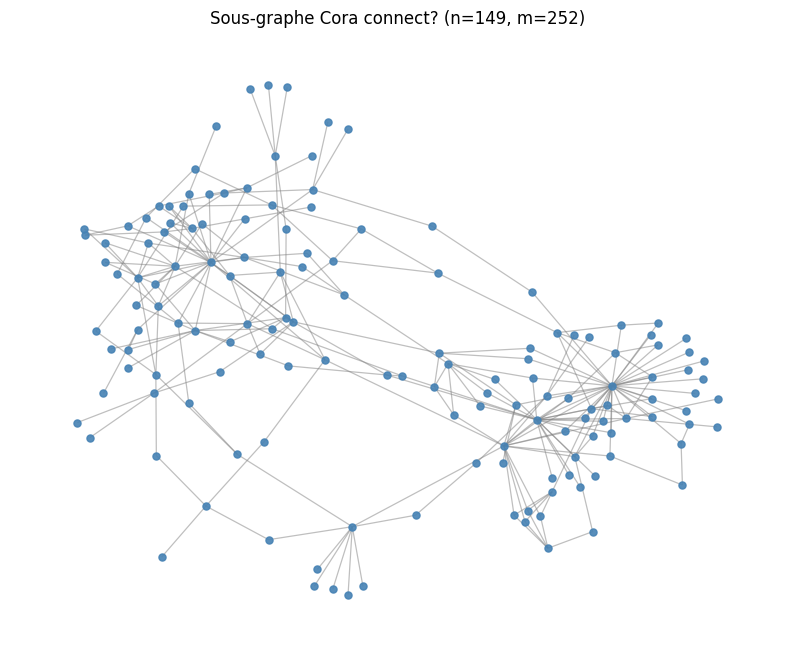

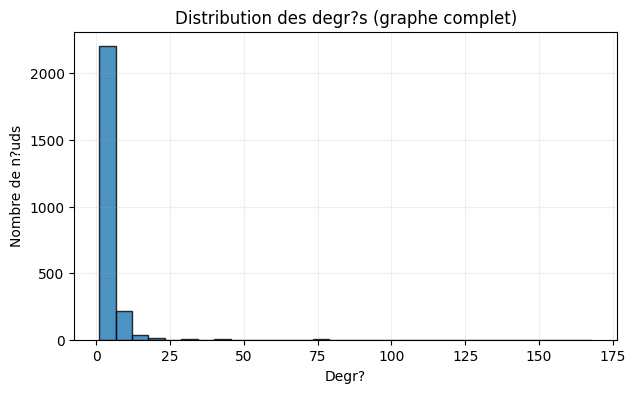

Stats degr?s -> min: 1 | max: 168 | mean: 4.0797
Subgraph used -> n: 149 | m: 252


In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

if 'G' not in globals():
    raise RuntimeError('Ex?cute d abord les cellules de chargement pour cr?er G.')

# Param?tres de visualisation (plus proche du graphe r?el)
MAX_VIS_N = 600     # augmente vers 800-1200 si ta machine suit
BFS_DEPTH = 3       # 2 ou 3 selon la densit? souhait?e

# 1) Sous-graphe CONNECT? plus grand (BFS)
start = random.choice(list(G.nodes()))
nodes_bfs = list(nx.bfs_tree(G, source=start, depth_limit=BFS_DEPTH).nodes())
if len(nodes_bfs) > MAX_VIS_N:
    random.seed(42)
    nodes_bfs = random.sample(nodes_bfs, MAX_VIS_N)
G_small = G.subgraph(nodes_bfs).copy()

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_small, seed=42, k=0.22, iterations=80)
nx.draw_networkx_edges(G_small, pos, edge_color='gray', width=0.9, alpha=0.5)
nx.draw_networkx_nodes(G_small, pos, node_size=26, node_color='steelblue', alpha=0.9)
plt.title(f'Sous-graphe Cora connect? (n={G_small.number_of_nodes()}, m={G_small.number_of_edges()})')
plt.axis('off')
plt.show()

# 2) Distribution des degr?s (graphe complet)
deg = np.array([d for _, d in G.degree()])
plt.figure(figsize=(7, 4))
plt.hist(deg, bins=30, edgecolor='black', alpha=0.8)
plt.title('Distribution des degr?s (graphe complet)')
plt.xlabel('Degr?')
plt.ylabel('Nombre de n?uds')
plt.grid(alpha=0.2)
plt.show()

print('Stats degr?s -> min:', int(deg.min()), '| max:', int(deg.max()), '| mean:', round(float(deg.mean()), 4))
print('Subgraph used -> n:', G_small.number_of_nodes(), '| m:', G_small.number_of_edges())


,Set,Count
0,Train edges,4563
1,Test positive edges,506
2,Test negative pairs,506


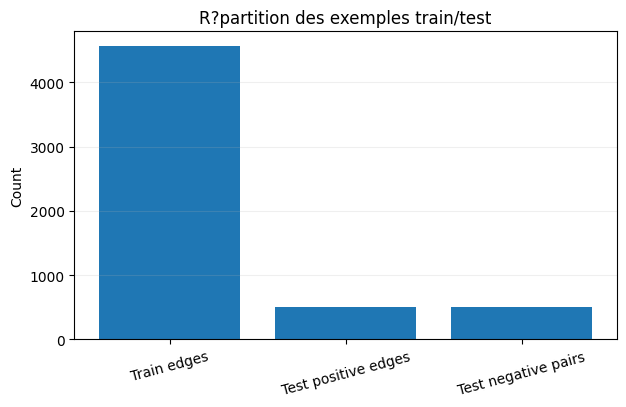

,Method,AUC,AP
0,Node2Vec + LR,0.915965,0.921253
1,Adamic-Adar,0.793861,0.795052
2,Common Neighbors,0.792697,0.789745
3,Jaccard,0.791506,0.786796


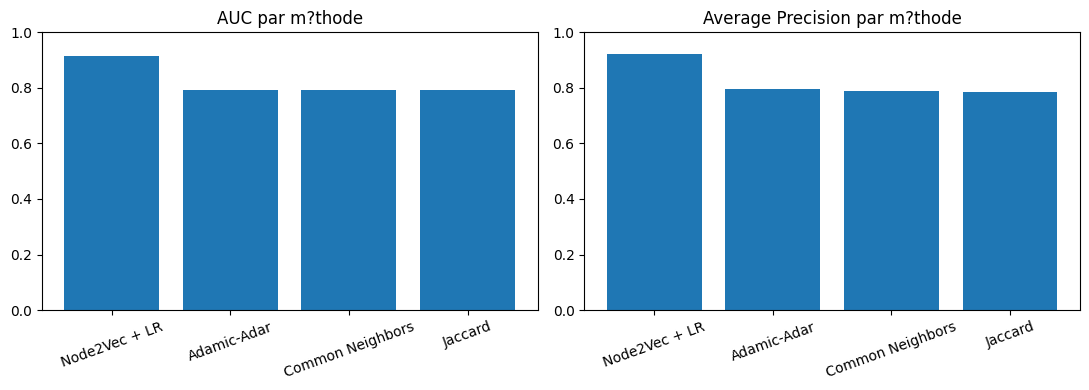

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

if 'G_train' not in globals() or 'test_pos' not in globals() or 'test_neg' not in globals():
    raise RuntimeError('Ex?cute d abord la cellule split pour cr?er G_train, test_pos, test_neg.')

# 3) R?partition train/test
counts = {
    'Train edges': G_train.number_of_edges(),
    'Test positive edges': len(test_pos),
    'Test negative pairs': len(test_neg),
}
df_counts = pd.DataFrame({'Set': list(counts.keys()), 'Count': list(counts.values())})
display(df_counts)

plt.figure(figsize=(7, 4))
plt.bar(df_counts['Set'], df_counts['Count'])
plt.title('R?partition des exemples train/test')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.2)
plt.show()

# 4) Comparaison des performances
metrics_rows = []
for name, fn in [
    ('Common Neighbors', common_neighbors_score if 'common_neighbors_score' in globals() else None),
    ('Jaccard', jaccard_score if 'jaccard_score' in globals() else None),
    ('Adamic-Adar', adamic_adar_score if 'adamic_adar_score' in globals() else None),
]:
    if fn is not None and 'evaluate_method' in globals():
        auc, ap = evaluate_method(G_train, test_pos, test_neg, fn)
        metrics_rows.append({'Method': name, 'AUC': auc, 'AP': ap})

# Add Node2Vec + LR if y_test/y_scores exist
if 'y_test' in globals() and 'y_scores' in globals():
    from sklearn.metrics import roc_auc_score, average_precision_score
    metrics_rows.append({
        'Method': 'Node2Vec + LR',
        'AUC': roc_auc_score(y_test, y_scores),
        'AP': average_precision_score(y_test, y_scores),
    })

if len(metrics_rows) == 0:
    print('Aucune m?trique disponible pour l?instant. Ex?cute d abord les cellules d??valuation.')
else:
    df_metrics = pd.DataFrame(metrics_rows).sort_values('AUC', ascending=False).reset_index(drop=True)
    display(df_metrics)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    axes[0].bar(df_metrics['Method'], df_metrics['AUC'])
    axes[0].set_title('AUC par m?thode')
    axes[0].set_ylim(0.0, 1.0)
    axes[0].tick_params(axis='x', rotation=20)

    axes[1].bar(df_metrics['Method'], df_metrics['AP'])
    axes[1].set_title('Average Precision par m?thode')
    axes[1].set_ylim(0.0, 1.0)
    axes[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()
